This notebook analyzes the possibility of using a spin-off of the mean-reversion investment strategy.
In short the idea of the strategy is to have half your capital invested and half in cash, then rebalance back to 50/50 periodically (i.e. sell when market goes up and buy when it goes down). The problem with this strategy is that it requires a constant mean. That's where the lstm comes in. Assuming that the lstm models the true stock price perfectly and that the markets stock price may deviate from it in a normally distributed way and the stock market price and the lstm price move in the same direction more often than not the market price will revert to the lstm price. This way we can use the mean-reversion strategy in a modern way.
To test this hypothesis I will first use this notebook to see if the market stock price is normally distributed about the lstm price and if the two prices genrally move in the same direction. I will then construct another script to backtest the strategy.

In [1]:
import quandl
from datetime import datetime, timedelta
from pandas import Series, concat, DataFrame
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_stock(ticker, start, end, time_range):
    #Retrive Stock Data Using Quandl
    stock = quandl.get('WIKI/{}'.format(ticker), start_date=start, end_date=end)
    #Keep Only Adjusted Closing Price And Adjusted Volume
    stock = stock.iloc[:,10:12]
    #Resample For Given Time Period
    stock = stock.resample('{}'.format(time_range)).mean()
    stock.dropna(inplace=True)
    return stock

In [3]:
def preprocess(data):
    #Transform Data and Calculate Percent Change
    data = np.log(data)
    percent_changes = np.empty(data.shape)
    for i in range(1, len(data)):
        percent_changes[i,:] = (data[i,:] - data[i-1,:])/data[i-1,:]
    return percent_changes

In [4]:
def series_to_supervised(data, n_in, n_out):
    #Convert The Data To A Supervised Learning Format
    cols = []
    df = DataFrame(data)
    for i in range(0, n_in+n_out):
        cols.append(df.shift(-i))
    data = concat(cols, axis=1)
    data.dropna(inplace=True)
    return data.values

In [5]:
def scale(train,test):
    #Scale The Data Using MinMax
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [6]:
def forecast_lstm(model, batch_size, X):
    #Forecasts The Average Price Of The Next Time Period
    X = X.reshape(1, len(X), 1)
    prediction = model.predict(X, batch_size=batch_size)
    return prediction[0,0]

In [7]:
def inverse_scale(predict, X, scaler):
    #Inverse Scales The Data
    new_row = [x for x in X] + [predict]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inv_scale = scaler.inverse_transform(array)
    return inv_scale[0,-1]

In [8]:
def inverse_preprocess(orig_data, predict, previous):
    #Inverse Percent Change And Transformation To Obtain The Actual Value
    inv_change = (predict + 1)*np.log(orig_data[-previous,0])
    return np.exp(inv_change)

In [9]:
#Stock Ticker
ticker = 'FMC'
#Timeframe of stock price data to r
train_start = datetime(2010,1,1)
train_end = datetime(2015,12,31)
test_end = datetime(2017,10,19)
#Time range ['M', 'W', 'D', 'A', 'Q']
time_range = 'D'
#Name of lstm model to be saved
model_name = 'model_10_15_D.h5'
#Number of time instances to test on
test_inst = 12
#Number of past stock prices and volumes to use to predict future prices
num_prev = 4
#Number of future stock prices to predict
#Keep at 1 for now, script not updated yet
num_pred = 1
#Batch Size
batch_size = 1

Retrieving Stock Data...
Preprocessing and Formatting Data...
Fitting and Testing Model...


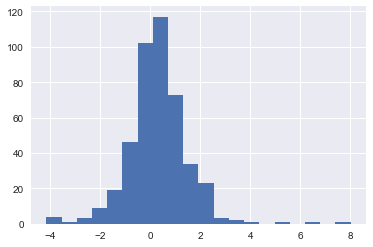

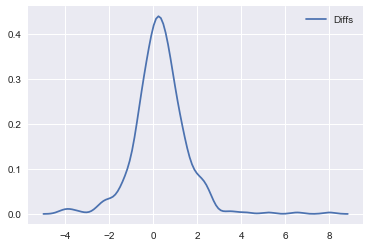

In [10]:
print('Retrieving Stock Data...')
data = get_stock(ticker, train_start, test_end, time_range)
train, test = data[:train_end-timedelta(days=test_inst)].values, data[train_end+timedelta(days=test_inst+num_prev):].values

print('Preprocessing and Formatting Data...')
train_preprocessed = preprocess(train)
test_preprocessed = preprocess(test)

train_formatted = series_to_supervised(train_preprocessed, num_prev, num_pred)
test_formatted = series_to_supervised(test_preprocessed, num_prev, num_pred)
#Drop Last Volume Row As We Are Only Predicting Stock Price
train_formatted = train_formatted[:,:-1]
test_formatted = test_formatted[:,:-1]
scaler, train_scaled, test_scaled = scale(train_formatted, test_formatted)

print('Fitting and Testing Model...')
error_scores = []
model = load_model(model_name)
predictions = []
for j in range(len(test_scaled)):
    X = test_scaled[j,0:-1]
    pred = forecast_lstm(model, batch_size, X)
    pred_invScale = inverse_scale(pred, X, scaler)
    pred_actual = inverse_preprocess(data.values, pred_invScale,len(test_scaled)+1-j)
    predictions.append(pred_actual)

results = DataFrame()
results['Diffs'] = test[num_prev:,0] - np.array(predictions)

plt.hist(results['Diffs'],20)
plt.show()

sns.kdeplot(results['Diffs'])

In [11]:
results.describe()

,Diffs
count,440.000000
mean,0.318792
std,1.207513
min,-4.154541
25%,-0.297324
50%,0.287260
75%,0.895635
max,8.007180


In [41]:
#Calculate Percent of the time the past Market price moves in the 
#same direction to the next Market Price and to the next LSTM price
direction = DataFrame()
#Change from between past Market Price and next LSTM Price
direction['lstm'] = np.array(predictions)[1:] - test[num_prev:-1,0]
#Change from between past Market Price and next Market Price
direction['market'] = np.diff(test[num_prev:,0])
#Positive means they moved in same direction, negative opposite direction
direction['product'] = direction['market']*direction['lstm']
#All the times they moved in same direction
same_direction = direction[direction['product']>=0]
percent = 100*len(same_direction)/len(direction)
print('Percent of Market Price and LSTM Price Moving in the same Direction: {}'.format(round(percent,3)))

Percent of Market Price and LSTM Price Moving in the same Direction: 51.025


The Market Price and the LSTM Price move in the same dircetion just over 50% of the time and with the mean only slightly off from zero and the market stock price being normally distributed about the lstm price the spin-off version of mean-reverison may work. The only way to tell is to backtest it (next step) and the only way to truly 100% tell is to put it into production with the current market (next next step maybe?)